In [3]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === CONFIGURATION ===
red_teams = ['86254B', '3131V']
blue_teams = ['1065A', '2775V']
kpi_file = "innov_kpi_summary.csv"

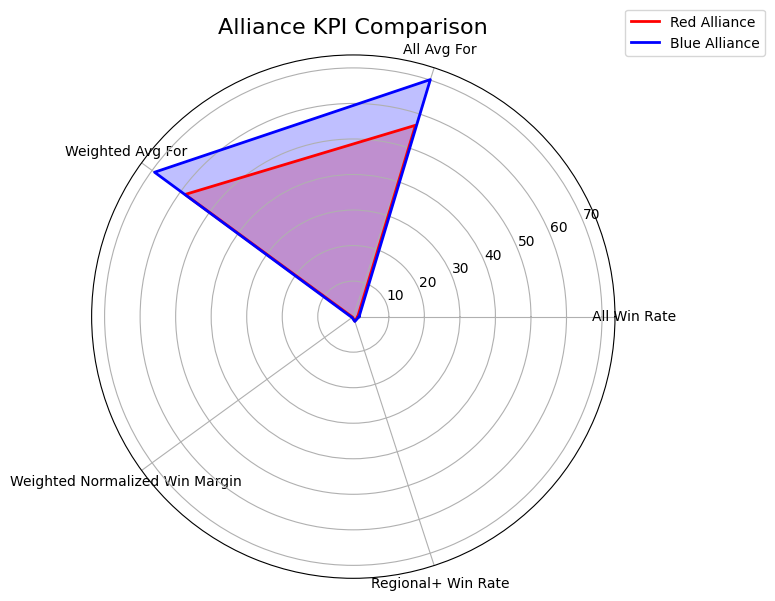

In [4]:
# === KPIs to Plot (with exact header names) ===
selected_kpis = [
    'All Win Rate',
    'All Avg For',
    'Weighted Avg For',
    'Weighted Normalized Win Margin',
    'Regional+ Win Rate'
]

# === Load KPI Data ===
kpi_df = pd.read_csv(kpi_file)

# Filter for the 4 teams
team_subset = red_teams + blue_teams
filtered_df = kpi_df[kpi_df['Team'].isin(team_subset)].copy()

if filtered_df.empty:
    raise ValueError("None of the specified teams found in KPI data.")

# === Function to Aggregate Alliance Scores ===
def compute_alliance_values(df, teams):
    alliance_df = df[df['Team'].isin(teams)]
    results = []
    for kpi in selected_kpis:
        top_two = alliance_df[kpi].nlargest(2).sum()
        results.append(top_two)
    return results

# === Compute Radar Chart Values ===
red_values = compute_alliance_values(filtered_df, red_teams)
blue_values = compute_alliance_values(filtered_df, blue_teams)

# === Radar Plot ===
labels = selected_kpis
num_vars = len(labels)

# Setup angles and data
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
red_values += red_values[:1]
blue_values += blue_values[:1]
angles += angles[:1]

# Create plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, red_values, color='red', linewidth=2, label='Red Alliance')
ax.fill(angles, red_values, color='red', alpha=0.25)

ax.plot(angles, blue_values, color='blue', linewidth=2, label='Blue Alliance')
ax.fill(angles, blue_values, color='blue', alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_title("Alliance KPI Comparison", size=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()